<a href="https://colab.research.google.com/github/eliasboughosn/Road-Signs-classification-Deep-Learning/blob/main/Road_Signs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline

In [ ]:
np.random.seed(0)

In [ ]:

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)



In [ ]:
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

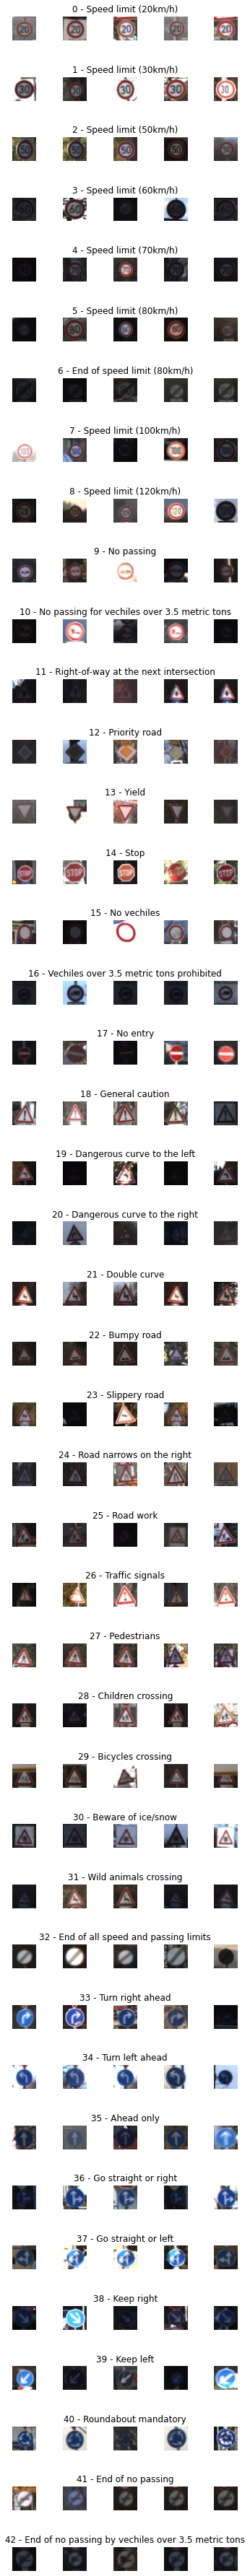

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


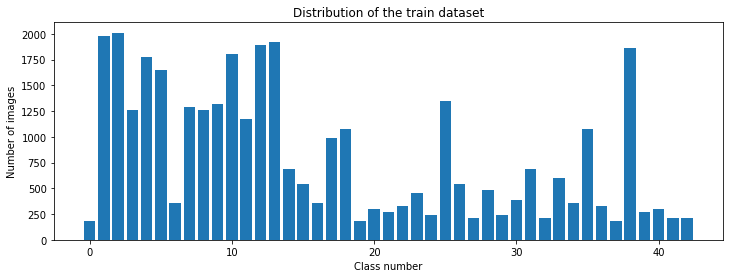

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


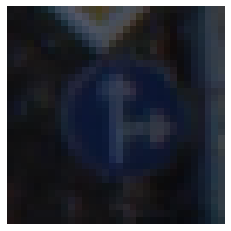

In [ ]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


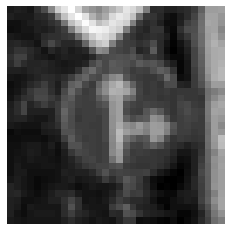

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


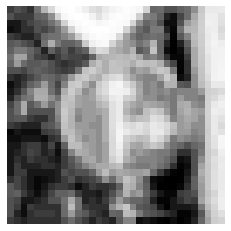

In [ ]:
img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [ ]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


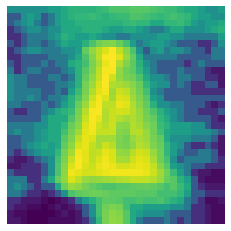

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

(15, 32, 32, 1)


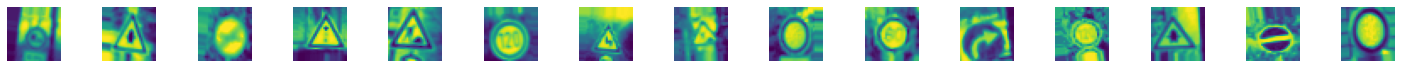

In [ ]:

 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:

 
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
 


In [ ]:
model = modified_model()
print(model.summary())
 
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),steps_per_epoch=2000,epochs=10,
                            validation_data=(X_val, y_val),verbose=1, shuffle = 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

Text(0.5, 0, 'epoch')

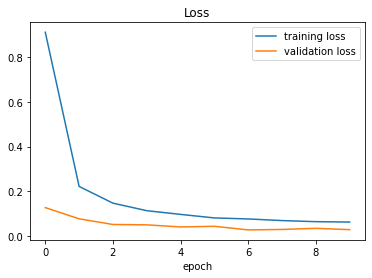

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.xlabel('epoch')
 

 



Text(0.5, 0, 'epoch')

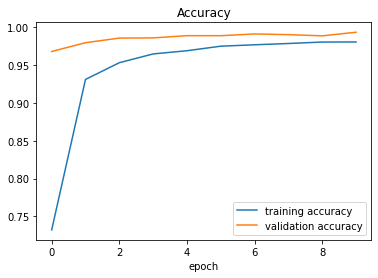

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy','validation accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
plot_history(histroy1.history)

NameError: ignored

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

Test accuracy: 97.21298217773438 %
(32, 32)
predicted sign: [9]No passing


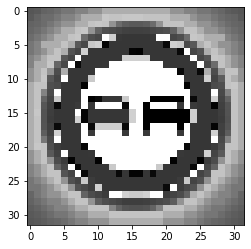

In [ ]:

print('Test accuracy:', score[1]*100, '%')
 
#predict internet number
import requests
from PIL import Image
url = 'https://i2.wp.com/autobahnsigns.com/wp-content/uploads/2017/08/No-Passing-Sign.jpg?fit=806%2C810'
#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTkPll7U_jYqoIqxzOP_5CY8_HrktLSGTtsoiCJtKcIa_Z4knuI  (20 speed limit)
#https://fscomps.fotosearch.com/compc/CSP/CSP145/20-miles-per-hour-speed-limit-sign-stock-image__k1456622.jpg  (30 speed limit)
#https://previews.123rf.com/images/tanjah7/tanjah71610/tanjah7161000001/66185812-speed-limit-50-kilometers-traffic-sign-isolated.jpg   (50 speed limit)
#https://previews.123rf.com/images/topdeq/topdeq1210/topdeq121000113/16061274-traffic-sign-speed-limit-70-against-blue-sky-vertical-shot.jpg (70 speed limit)
#https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT3zgQJH8DMLDgwHsS6c5geRFQITSHETPLr_QVDz3Hlcl-t_GSa (Speed limit 120km/h)
#https://i2.wp.com/autobahnsigns.com/wp-content/uploads/2017/08/No-Passing-Sign.jpg?fit=806%2C810 (no passing)
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
prediction_nbr=int(model.predict_classes(img))

print("predicted sign: "+str(model.predict_classes(img)) +data.SignName[prediction_nbr]   )

In [ ]:
layer1=Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
layer2=Model(inputs=model.layers[0].input, outputs=model.layers[1].output)
layer3=Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
layer4=Model(inputs=model.layers[0].input, outputs=model.layers[4].output)

layer1_shape,layer2_shape,layer3_shape,layer4_shape=layer1.predict(img),layer2.predict(img),layer3.predict(img), layer4.predict(img)
print(layer1_shape.shape)
print(layer2_shape.shape)
print(layer3_shape.shape)
print(layer4_shape.shape)

(1, 28, 28, 60)
(1, 24, 24, 60)
(1, 10, 10, 30)
(1, 8, 8, 30)


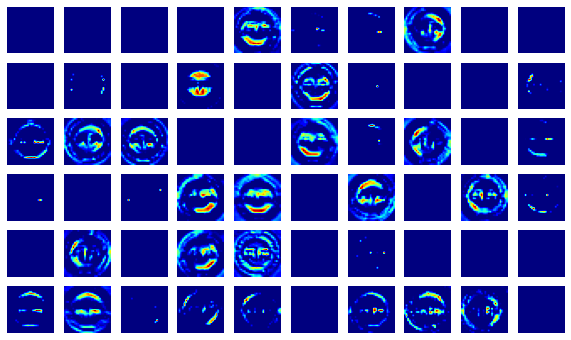

In [ ]:
plt.figure(figsize=(10,6))
for i in range (layer1_shape.shape[3]):
  plt.subplot(6,10,i+1)
  plt.imshow(layer1_shape[0,:,:,i],cmap=plt.get_cmap('jet'))
  plt.axis('off')

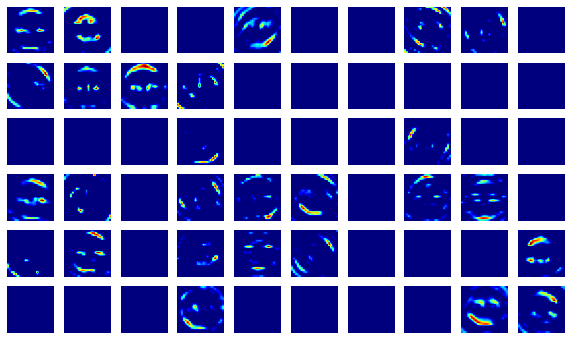

In [ ]:
plt.figure(figsize=(10,6))
for i in range (layer2_shape.shape[3]):
  plt.subplot(6,10,i+1)
  plt.imshow(layer2_shape[0,:,:,i],cmap=plt.get_cmap('jet'))
  plt.axis('off')

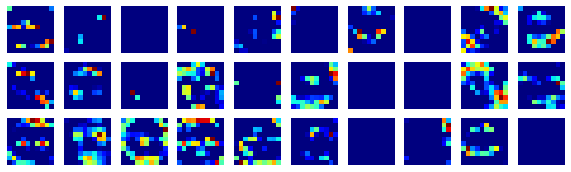

In [ ]:
plt.figure(figsize=(10,6))
for i in range (layer3_shape.shape[3]):
  plt.subplot(6,10,i+1)
  plt.imshow(layer3_shape[0,:,:,i],cmap=plt.get_cmap('jet'))
  plt.axis('off')

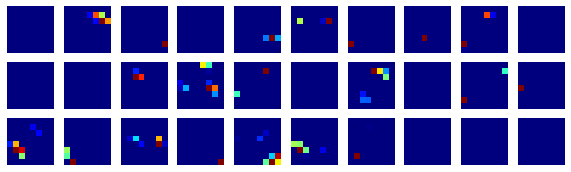

In [ ]:
plt.figure(figsize=(10,6))
for i in range (layer4_shape.shape[3]):
  plt.subplot(6,10,i+1)
  plt.imshow(layer4_shape[0,:,:,i],cmap=plt.get_cmap('jet'))
  plt.axis('off')